<a href="https://colab.research.google.com/github/Yi-Wei-Lin/Tibame_ML_20210602/blob/main/0712_Cabbage_predict_shift.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [123]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [124]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [125]:
# data = pd.read_excel("Cabbage.xlsx")
data = pd.read_excel("/content/drive/MyDrive/市場批發交易歷史資料/Cabbage.xlsx")

In [126]:
data = data.dropna()
data = data.loc[data["Market"] == "台北一"]
np.array(data["Avg_price"]).reshape(-1,1)

array([[ 8.9],
       [ 7.2],
       [ 6.7],
       ...,
       [15.1],
       [15.1],
       [15.5]])

In [127]:
# data_train = data[data["Date"] < "2019-01-01"]
# data_test = data[data["Date"] >= "2019-01-01"]
data_train = data

In [128]:
data_train = data_train.drop(["Market", "Product", "Month", "Week_day", "Year", "Rest_day"], axis=1)
data_train

,Date,Up_price,Mid_price,Low_price,Avg_price,Volume
39204,2000-01-02,11.0,8.0,5.0,8.9,192029.0
39205,2000-01-03,9.0,7.0,4.0,7.2,174270.0
39206,2000-01-04,8.0,6.0,3.0,6.7,125426.0
39207,2000-01-05,10.0,7.0,4.0,7.1,119318.0
39208,2000-01-06,9.0,7.0,5.0,6.8,118178.0
...,...,...,...,...,...,...
47037,2021-06-13,23.0,15.6,6.2,15.2,174973.0
47038,2021-06-14,27.4,21.4,13.6,21.0,128693.0
47041,2021-06-17,21.8,15.0,8.5,15.1,96289.0
47042,2021-06-18,21.9,15.2,8.1,15.1,148701.0


In [129]:
# from tensorflow.keras.utils import to_categorical
# pd.DataFrame(to_categorical(data_train["Month"]))

In [130]:
# preparing label data
day = 3
Cabbage_shift = data_train.shift(-day)
label = Cabbage_shift['Avg_price']

# adjusting the shape of both
data_train = data_train.drop(data_train.index[len(data_train)-day:], axis=0)
label = label.drop(label.index[len(label)-day:], axis=0)

# conversion to numpy array
x, y = data_train.values, label.values

In [131]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33)

In [132]:
x_test.reshape(-1,6).shape
test_date = pd.DataFrame(x_test.reshape(-1,6))[0]

In [133]:
x_train = x_train[:,1:]
x_test = x_test[:,1:]

In [134]:
x_test

array([[12.8, 7.2, 3.4, 7.6, 226338.0],
       [9.3, 7.1, 4.7, 7.1, 84882.0],
       [7.2, 4.5, 3.3, 4.8, 198474.0],
       ...,
       [5.3, 3.8, 2.0, 3.7, 144355.0],
       [21.4, 16.0, 11.2, 16.1, 90595.0],
       [18.7, 9.9, 4.8, 10.6, 236534.0]], dtype=object)

In [135]:
Xscaler = MinMaxScaler()
Yscaler = MinMaxScaler()
x_train = Xscaler.fit_transform(x_train)
y_train = Yscaler.fit_transform(y_train.reshape(-1,1))

In [136]:
# splitting train and test
x_train = x_train.reshape((-1,1,5))
x_test = x_test.reshape((-1,1,5))

In [137]:
# data_train = np.concatenate((data_xtrain, data_ytrain), axis=1)


In [138]:
# x_train = []
# y_train = []
# time_step = 60
# for i in range(len(data_train) - time_step):
#   x_train.append(data_train[i:(i+time_step)])
#   y_train.append(data_train[(i+time_step)][-1])
# x_train, y_train = np.array(x_train), np.array(y_train).reshape(-1,1)

In [139]:
# Building LSTM model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU
layers = [
    LSTM(units=256, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])),
    Dropout(0.2),
    # LSTM(units=256, return_sequences=True),
    # Dropout(0.2),
    # LSTM(units=256, return_sequences=True),
    # Dropout(0.2),
    LSTM(units=256),
    Dropout(0.2),
    # Dense(units=5, activation="sigmoid"),
    Dense(units=1, activation="linear")
]
regressor = Sequential(layers)
regressor.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 1, 256)            268288    
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 256)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 793,857
Trainable params: 793,857
Non-trainable params: 0
_________________________________________________________________


In [140]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from keras.callbacks import EarlyStopping, ModelCheckpoint
regressor.compile(loss = "mse",
         optimizer = Adam(),
         metrics=["mse"]                   
)
callback = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ModelCheckpoint("regressor.h5", save_best_only=True)
]
regressor.fit(x_train, y_train, epochs=200, batch_size=32, validation_split=0.1, callbacks=callback)
# regressor.fit(x_train, y_train, epochs=40, batch_size=40, validation_split=0.1)

Epoch 1/200
123/123 [==============================] - 7s 23ms/step - loss: 0.0082 - mse: 0.0082 - val_loss: 0.0040 - val_mse: 0.0040
Epoch 2/200
123/123 [==============================] - 2s 16ms/step - loss: 0.0038 - mse: 0.0038 - val_loss: 0.0038 - val_mse: 0.0038
Epoch 3/200
123/123 [==============================] - 2s 16ms/step - loss: 0.0037 - mse: 0.0037 - val_loss: 0.0040 - val_mse: 0.0040
Epoch 4/200
123/123 [==============================] - 2s 16ms/step - loss: 0.0037 - mse: 0.0037 - val_loss: 0.0039 - val_mse: 0.0039
Epoch 5/200
123/123 [==============================] - 2s 16ms/step - loss: 0.0037 - mse: 0.0037 - val_loss: 0.0040 - val_mse: 0.0040
Epoch 6/200
123/123 [==============================] - 2s 16ms/step - loss: 0.0037 - mse: 0.0037 - val_loss: 0.0038 - val_mse: 0.0038
Epoch 7/200
123/123 [==============================] - 2s 16ms/step - loss: 0.0037 - mse: 0.0037 - val_loss: 0.0038 - val_mse: 0.0038
Epoch 8/200
123/123 [==============================] - 2s 16ms

In [141]:
# plt.plot(regressor.regressor['loss'], color = 'red')
# plt.plot(regressor.regressor['val_loss'], color = 'bule')

In [142]:
# past_60_days = data[data["Date"] < "2019-01-01"].tail(time_step)
# df = past_60_days.append(data_test, ignore_index = True)
# df = df.drop(["Date", "Market", "Product", "Month", "Week_day", "Year", "Rest_day"], axis=1)
# df

In [143]:
# real_avg_price = np.array(df.iloc[time_step:]["Avg_price"]).reshape(-1,1)
# ytest = np.array(df["Avg_price"]).reshape(-1,1)
# x_inputs = Xscaler.transform(df.drop(["Avg_price"], axis=1))
# y_inputs = Yscaler.transform(ytest)

In [144]:
# inputs = np.concatenate((x_inputs, y_inputs), axis=1)

In [145]:
# x_test = []
# y_test = []
# time_step = 60
# for i in range(len(inputs) - time_step):
#   x_test.append(inputs[i:(i+time_step)])
#   y_test.append(inputs[(i+time_step)][-1])
# yy = y_test
# x_test, y_test = np.array(x_test), np.array(y_test).reshape(-1,1)

In [147]:
x_test = Xscaler.transform(x_test.reshape(-1,5))
y_test = Yscaler.transform(y_test.reshape(-1,1))

ValueError: ignored

In [151]:
x_test = x_test.reshape(-1,1,5)
pre_price = regressor.predict(x_test)
pre_price = Yscaler.inverse_transform(pre_price)

In [152]:
y_test = Yscaler.inverse_transform(y_test)

In [180]:
test_date = np.array(test_date).reshape(-1,1)
np.concatenate((y_test, pre_price), axis=1)
# pre_price
# y_test.reshape(-1)
# pre_price.shape()
test_date

array([['2014-05-03T00:00:00.000000000'],
       ['2004-03-31T00:00:00.000000000'],
       ['2010-01-03T00:00:00.000000000'],
       ...,
       ['2008-04-17T00:00:00.000000000'],
       ['2013-07-26T00:00:00.000000000'],
       ['2019-03-15T00:00:00.000000000']], dtype='datetime64[ns]')

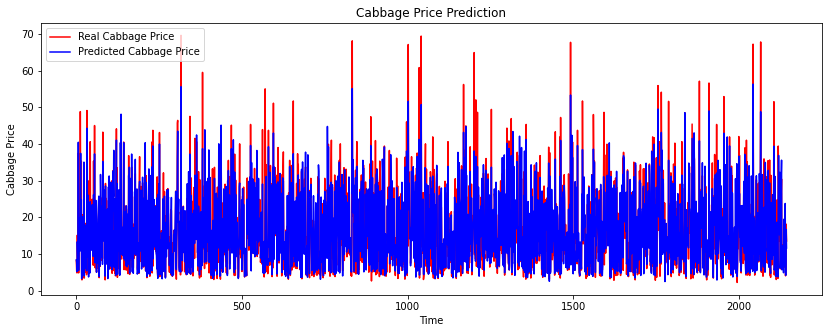

In [153]:
# Visualising the results
plt.figure(figsize=(14,5))
plt.plot(y_test, color = 'red', label = 'Real Cabbage Price')
plt.plot(pre_price, color = 'blue', label = 'Predicted Cabbage Price')
plt.title('Cabbage Price Prediction')
plt.xlabel('Time')
plt.ylabel('Cabbage Price')
plt.legend()
plt.show()

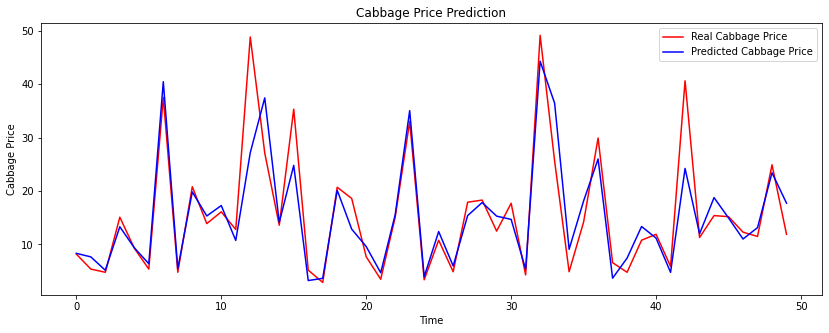

In [154]:
# Visualising the results
plt.figure(figsize=(14,5))
plt.plot(y_test[0:50], color = 'red', label = 'Real Cabbage Price')
plt.plot(pre_price[0:50], color = 'blue', label = 'Predicted Cabbage Price')
plt.title('Cabbage Price Prediction')
plt.xlabel('Time')
plt.ylabel('Cabbage Price')
plt.legend()
plt.show()

In [156]:
# MSE & RMSE 計算
# sklearn.metrics.mean_squared_error(y_true, y_pred)
# sklearn.metrics.r2_score(y_true, y_pred)
from sklearn.metrics import mean_squared_error, r2_score
MSE = mean_squared_error(y_test, pre_price)
RMSE = np.sqrt(MSE)
R2 = r2_score(y_test, pre_price)
print(f"MSE value : {MSE}", f"\nRMSE value : {RMSE}", f"\nR2 score value : {R2}")

MSE value : 17.72841259234383 
RMSE value : 4.210512153211748 
R2 score value : 0.8564789500810783
